# Imports

In [1]:
import sys
import math
import statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import *
from decimal import Decimal
from IPython.display import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Quick Links

<ol>
    <li><a href=#find_motif>Motif Discovery</a></li>
    <li><a href=#score_dist>Score Distribution</a></li>
    <li><a href=#sig_snps>Significant SNPs</a></li>
    <li><a href=#neg_snps>Negative Scoring SNPs</a></li>
    <li><a href=#pos_snps>Positive Scoring SNPs</a></li>
    <li><a href=#final_table>Final SNP Table</a></li>
</ol>

## Choose Cluster

In [2]:
cluster_input = 14

# Prepare Scores

In [3]:
cluster = str(cluster_input)
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print()
print("Num effect sequences:", '\t', '\t', len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", '\t', len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

print("Num scores:", '\t', '\t', '\t', len(noneffect_onehot))

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)


Num effect sequences: 	 	 435
Num noneffect sequences: 	 435
Num scores: 	 	 	 435


# Model the Distribution of Importance Scores <a name='find_motif' />

In [4]:
sig_list = []
ksvals = []
motifs = []

for seq in range(len(effect_onehot)):
    if merged_ism_scores[seq] >= 0:
        scores = [np.sum(j) for j in merged_effect_scores[seq][400:600]]
    else:
        scores = [np.sum(j) for j in merged_noneffect_scores[seq][400:600]]
    shape, mean, stdev = t.fit(scores)
    kstat, kval = stats.kstest(scores, 't', args=[shape, mean, stdev])
    if merged_ism_scores[seq] >= 0:
        pvals = t.cdf([np.sum(j) for j in merged_effect_scores[seq]], shape, mean, stdev)
    else:
        pvals = t.cdf([np.sum(j) for j in merged_noneffect_scores[seq]], shape, mean, stdev)
    ksvals.append([kstat, kval])
    
    start = 499
    end = 499
    while True:
        if pvals[start - 1] <= 0.95:
            if pvals[start - 2] <= 0.95:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if pvals[end] <= 0.95:
            if pvals[end + 1] <= 0.95:
                break
            else:
                end += 1
        else:
            end += 1

    if merged_ism_scores[seq] >= 0:
        if start != end:
            motif = effect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = effect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
        else:
            mstart = start - 4
            mend = end + 6
            motif = effect_seqs[seq][mstart:mend]
    else:
        if start != end:
            motif = noneffect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = noneffect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
                
        else:
            mstart = start - 4
            mend = end + 6
            motif = noneffect_seqs[seq][mstart:mend]
    
    motifs.append(motif)
    sig_list.append([start, end, shape, mean, stdev, mstart, mend])

sig_list_stats = [x[1]-x[0] for x in sig_list if x[1]-x[0] != 0]
all_list_stats = [len(x) for x in motifs]
ksvals_pvals = [x[1] for x in ksvals]
sig_ksvals = [x for x in ksvals_pvals if x < 0.01]
print()
print('Mean KS-test p-value:', '\t', '\t', statistics.mean(ksvals_pvals))
print('Median KS-test p-value:', '\t', statistics.median(ksvals_pvals))
print('St. Dev KS-test p-value:', '\t', statistics.stdev(ksvals_pvals))
print('Max KS-test p-value:', '\t', '\t', max(ksvals_pvals))
print('Min KS-test p-value:', '\t', '\t', min(ksvals_pvals))
print('Num significant p-values:', '\t', len(sig_ksvals))
print()
print('Mean non-zero motif length:', '\t', statistics.mean(sig_list_stats))
print('Median non-zero motif length:', '\t', statistics.median(sig_list_stats))
print('St. Dev non-zero motif length:', '\t', statistics.stdev(sig_list_stats))
#print('Mode non-zero motif length:', '\t', statistics.mode(sig_list_stats))
print('Max non-zero motif length:', '\t', max(sig_list_stats))
print('Min non-zero motif lenght:', '\t', min(sig_list_stats))
print()
print('Mean motif length:', '\t', '\t', statistics.mean(all_list_stats))
print('Median motif length:', '\t', '\t', statistics.median(all_list_stats))
print('St. Dev motif length:', '\t', '\t', statistics.stdev(all_list_stats))
#print('Mode motif length:', '\t', '\t', statistics.mode(all_list_stats))
print('Max motif length:', '\t', '\t', max(all_list_stats))
print('Min motif lenght:', '\t', '\t', min(all_list_stats))


Mean KS-test p-value: 	 	 0.4563728315443379
Median KS-test p-value: 	 0.46489572681998775
St. Dev KS-test p-value: 	 0.30734152266606984
Max KS-test p-value: 	 	 0.9985082144101154
Min KS-test p-value: 	 	 3.063790662890814e-09
Num significant p-values: 	 28

Mean non-zero motif length: 	 9.27450980392157
Median non-zero motif length: 	 9.0
St. Dev non-zero motif length: 	 5.8185313989268375
Max non-zero motif length: 	 27
Min non-zero motif lenght: 	 1

Mean motif length: 	 	 10.8
Median motif length: 	 	 10
St. Dev motif length: 	 	 2.639473484711998
Max motif length: 	 	 27
Min motif lenght: 	 	 7


# Prepare DataFrame

In [5]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                   +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')

effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
orig_score = []
diff_score = []
ratio_score = []
ism_score = []
delta_score = []
idr_peak = []
gwas = []
gwas_pval = []
coloc = []

for index,row in snps.iterrows():
    
    orig_eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][475:525]]))
    eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    eff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                        for j in \
                                        merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    effect_center.append(eff_cent)
    
    orig_noneff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_noneffect_scores[index][475:525]]))
    noneff_cent = np.sum(np.array([np.sum(j) \
                                   for j in \
                                   merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                           for j in \
                                           merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneffect_center.append(noneff_cent)
    
    eff_bg = np.sum(np.array([max(0, np.sum(j)) \
                              for j in merged_effect_scores[index][400:600]]))
    eff_rat = eff_cent_nonzero / eff_bg
    effect_ratio.append(eff_rat)
    
    noneff_bg = np.sum(np.array([max(0, np.sum(j)) \
                                 for j in merged_noneffect_scores[index][400:600]]))
    noneff_rat = noneff_cent_nonzero / noneff_bg
    noneffect_ratio.append(noneff_rat)
    
    orig_score.append(orig_eff_cent - orig_noneff_cent)
    if (sig_list[index][1] - sig_list[index][0]) > 0:
        diff_score.append(eff_cent_nonzero - noneff_cent_nonzero)
        ratio_score.append(eff_rat - noneff_rat)
    else:
        diff_score.append('NAN')
        ratio_score.append('NAN')
    
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    lowest_pval = 1
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        if rw['has_coloc'] == True:
            has_coloc = True
        if rw['pvalue'] < lowest_pval:
            gwas_list = rw['source_gwas']
            lowest_pval = rw['pvalue']
    gwas.append(gwas_list)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)

snps.effect.replace('NAN', 'Z', inplace=True)
snps.noneffect.replace('NAN', 'Z', inplace=True)
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['orig_score'] = orig_score
snps['diff_score'] = diff_score
snps['ratio_score'] = ratio_score
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['gwas'] = gwas
snps['gwas_pval'] = gwas_pval
snps['coloc'] = coloc
snps['idr_peak'] = idr_peak
snps['motif'] = motifs
snps.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
snps.sort_values(by=['rsid', 'effect'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)
snps.effect.replace('Z', 'NAN', inplace=True)
snps.noneffect.replace('Z', 'NAN', inplace=True)
print()
print('Number of Unique SNPs:', len(snps))

/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Number of Unique SNPs: 394


## Distribution of Original gkmExplain Scores <a name='score_dist' />


Number of SNPs with significant motifs: 394


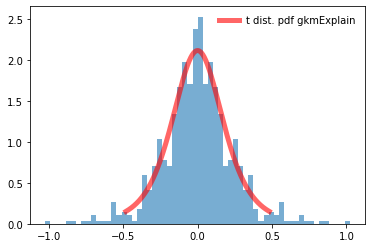

In [6]:
true_orig_scores = snps.orig_score.tolist()
true_orig_scores = [i for i in true_orig_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_orig_scores))
oppo_orig_scores = [-1 * i for i in true_orig_scores]
orig_scores = true_orig_scores + oppo_orig_scores
orig_shape, orig_mean, orig_stdev = t.fit(orig_scores)
fig, ax = plt.subplots(1, 1)
orig_x = np.linspace(t.ppf(0.025, orig_shape, orig_mean, orig_stdev),
                t.ppf(0.975, orig_shape, orig_mean, orig_stdev), 1000)
ax.plot(orig_x, t.pdf(orig_x, orig_shape, orig_mean, orig_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(orig_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Original gkmExplain Scores

In [7]:
print()
print('Shape:', '\t', orig_shape)
print('Mean:', '\t', orig_mean)
print('Stdev:', '\t', orig_stdev)
print()
print(stats.kstest(orig_scores, 't', args=[orig_shape, orig_mean, orig_stdev]))


Shape: 	 4.2679374626404805
Mean: 	 -2.21229326736477e-07
Stdev: 	 0.17786429196744996

KstestResult(statistic=0.0210027350984775, pvalue=0.8777783411571346)


## Distribution of Non-Zero Difference gkmExplain Scores


Number of SNPs with significant motifs: 184


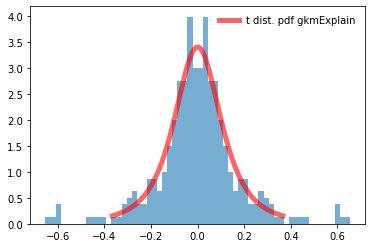

In [8]:
true_diff_scores = snps.diff_score.tolist()
true_diff_scores = [i for i in true_diff_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_diff_scores))
oppo_diff_scores = [-1 * i for i in true_diff_scores]
diff_scores = true_diff_scores + oppo_diff_scores
diff_shape, diff_mean, diff_stdev = t.fit(diff_scores)
fig, ax = plt.subplots(1, 1)
diff_x = np.linspace(t.ppf(0.025, diff_shape, diff_mean, diff_stdev),
                t.ppf(0.975, diff_shape, diff_mean, diff_stdev), 1000)
ax.plot(diff_x, t.pdf(diff_x, diff_shape, diff_mean, diff_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(diff_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Non-Zero Difference gkmExplain Scores

In [9]:
print()
print('Shape:', '\t', diff_shape)
print('Mean:', '\t', diff_mean)
print('Stdev:', '\t', diff_stdev)
print()
print(stats.kstest(diff_scores, 't', args=[diff_shape, diff_mean, diff_stdev]))


Shape: 	 2.658701501956141
Mean: 	 -3.7590774674349583e-07
Stdev: 	 0.10672372804779395

KstestResult(statistic=0.023383468336777513, pvalue=0.9878515925521585)


## Distribution of Ratio Difference gkmExplain Scores


Number of SNPs with significant motifs: 184


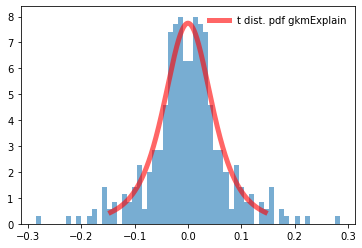

In [10]:
true_ratio_scores = snps.ratio_score.tolist()
true_ratio_scores = [i for i in true_ratio_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_ratio_scores))
oppo_ratio_scores = [-1 * i for i in true_ratio_scores]
ratio_scores = true_ratio_scores + oppo_ratio_scores
ratio_shape, ratio_mean, ratio_stdev = t.fit(ratio_scores)
fig, ax = plt.subplots(1, 1)
ratio_x = np.linspace(t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev),
                t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev), 1000)
ax.plot(ratio_x, t.pdf(ratio_x, ratio_shape, ratio_mean, ratio_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(ratio_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Ratio Difference gkmExplain Scores

In [11]:
print()
print('Shape:', '\t', ratio_shape)
print('Mean:', '\t', ratio_mean)
print('Stdev:', '\t', ratio_stdev)
print()
print(stats.kstest(ratio_scores, 't', args=[ratio_shape, ratio_mean, ratio_stdev]))


Shape: 	 3.2790685692446715
Mean: 	 4.08357410128736e-08
Stdev: 	 0.04780194330536778

KstestResult(statistic=0.029190496302727187, pvalue=0.9124543672753658)


## Distribution of ISM Scores

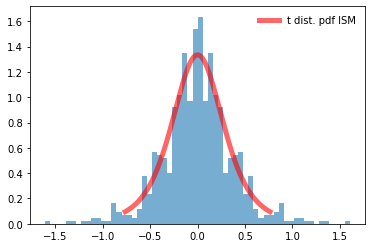

In [12]:
true_ism_scores = snps.ism_score.tolist()
oppo_ism_scores = [-1 * i for i in true_ism_scores]
ism_scores = true_ism_scores + oppo_ism_scores
ism_shape, ism_mean, ism_stdev = t.fit(ism_scores)
fig, ax = plt.subplots(1, 1)
ism_x = np.linspace(t.ppf(0.025, ism_shape, ism_mean, ism_stdev),
                t.ppf(0.975, ism_shape, ism_mean, ism_stdev), 1000)
ax.plot(ism_x, t.pdf(ism_x, ism_shape, ism_mean, ism_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf ISM')
ax.hist(ism_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for ISM Scores

In [13]:
print()
print('Shape:', '\t', ism_shape)
print('Mean:', '\t', ism_mean)
print('Stdev:', '\t', ism_stdev)
print()
print(stats.kstest(ism_scores, 't', args=[ism_shape, ism_mean, ism_stdev]))


Shape: 	 4.28047145268498
Mean: 	 -5.029672587060882e-07
Stdev: 	 0.28210217238671764

KstestResult(statistic=0.022740511908348582, pvalue=0.8098031464656571)


## Distribution of Delta Scores

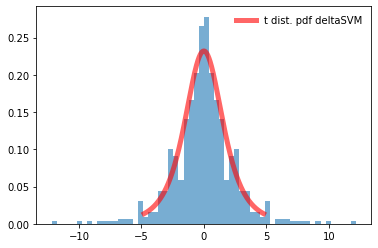

In [14]:
true_delta_scores = snps.delta_score.tolist()
oppo_delta_scores = [-1 * i for i in true_delta_scores]
delta_scores = true_delta_scores + oppo_delta_scores
delta_shape, delta_mean, delta_stdev = t.fit(delta_scores)
fig, ax = plt.subplots(1, 1)
delta_x = np.linspace(t.ppf(0.025, delta_shape, delta_mean, delta_stdev),
                t.ppf(0.975, delta_shape, delta_mean, delta_stdev), 1000)
ax.plot(delta_x, t.pdf(delta_x, delta_shape, delta_mean, delta_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf deltaSVM')
ax.hist(delta_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Delta Scores

In [15]:
print()
print('Shape:', '\t', delta_shape)
print('Mean:', '\t', delta_mean)
print('Stdev:', '\t', delta_stdev)
print()
print(stats.kstest(delta_scores, 't', args=[delta_shape, delta_mean, delta_stdev]))


Shape: 	 3.366110813284374
Mean: 	 5.728479007093776e-06
Stdev: 	 1.5977565163888552

KstestResult(statistic=0.020083878022983018, pvalue=0.9083128042409149)


# Get Significant SNPs

In [16]:
pd.set_option('mode.chained_assignment', None)

snps.orig_score.replace('NAN', 0.0, inplace=True)
snps.diff_score.replace('NAN', 0.0, inplace=True)
snps.ratio_score.replace('NAN', 0.0, inplace=True)

orig_pval = [2 * min(t.cdf(x, orig_shape, orig_mean, orig_stdev),
                        1 - t.cdf(x, orig_shape, orig_mean, orig_stdev)) \
                for x in snps['orig_score']]

diff_pval = [2 * min(t.cdf(x, diff_shape, diff_mean, diff_stdev),
                        1 - t.cdf(x, diff_shape, diff_mean, diff_stdev)) \
                for x in snps['diff_score']]

ratio_pval = [2 * min(t.cdf(x, ratio_shape, ratio_mean, ratio_stdev),
                        1 - t.cdf(x, ratio_shape, ratio_mean, ratio_stdev)) \
                for x in snps['ratio_score']]

ism_pval = [2 * min(t.cdf(x, ism_shape, ism_mean, ism_stdev),
                1 - t.cdf(x, ism_shape, ism_mean, ism_stdev)) \
            for x in snps['ism_score']]

delta_pval = [2 * min(t.cdf(x, delta_shape, delta_mean, delta_stdev),
                1 - t.cdf(x, delta_shape, delta_mean, delta_stdev)) \
            for x in snps['delta_score']]

kstest_pval = [ksvals_pvals[x] for x in snps.index]

snps['orig_pval'] = orig_pval
snps['diff_pval'] = diff_pval
snps['ratio_pval'] = ratio_pval
snps['ism_pval'] = ism_pval
snps['delta_pval'] = delta_pval
snps['kstest_pval'] = kstest_pval

neg_orig_cutoff = t.ppf(0.025, orig_shape, orig_mean, orig_stdev)
neg_diff_cutoff = t.ppf(0.025, diff_shape, diff_mean, diff_stdev)
neg_ratio_cutoff_low = t.ppf(0.1, ratio_shape, ratio_mean, ratio_stdev)
neg_ratio_cutoff_high = t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev)
neg_ism_cutoff = t.ppf(0.025, ism_shape, ism_mean, ism_stdev)
neg_delta_cutoff = t.ppf(0.025, delta_shape, delta_mean, delta_stdev)

snps.sort_values(by=['ratio_pval'], ascending=True, inplace=True)
neg_snps = snps.loc[(snps['orig_score'] < neg_orig_cutoff)
                    & (snps['ism_score'] < neg_ism_cutoff)
                    & (snps['delta_score'] < neg_delta_cutoff)]

pos_orig_cutoff = t.ppf(0.975, orig_shape, orig_mean, orig_stdev)
pos_diff_cutoff = t.ppf(0.975, diff_shape, diff_mean, diff_stdev)
pos_ratio_cutoff_low = t.ppf(0.9, ratio_shape, ratio_mean, ratio_stdev)
pos_ratio_cutoff_high = t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev)
pos_ism_cutoff = t.ppf(0.975, ism_shape, ism_mean, ism_stdev)
pos_delta_cutoff = t.ppf(0.975, delta_shape, delta_mean, delta_stdev)

pos_snps = snps.loc[(snps['orig_score'] > pos_orig_cutoff)
                    & (snps['ism_score'] > pos_ism_cutoff)
                    & (snps['delta_score'] > pos_delta_cutoff)]

neg_confidence = [0 for x in range(len(neg_snps))]
pos_confidence = [0 for x in range(len(pos_snps))]

counter = 0
for index, row in neg_snps.iterrows():
    if (row['ratio_score'] < neg_ratio_cutoff_high):
        neg_confidence[counter] = 2
    elif (row['ratio_score'] < neg_ratio_cutoff_low) or (row['diff_score'] < neg_diff_cutoff):
        neg_confidence[counter] = 1
    counter += 1
    
counter = 0
for index, row in pos_snps.iterrows():
    if (row['ratio_score'] > pos_ratio_cutoff_high):
        pos_confidence[counter] = 2
    elif (row['ratio_score'] > pos_ratio_cutoff_low) or (row['diff_score'] > pos_diff_cutoff):
        pos_confidence[counter] = 1
    counter += 1
    
neg_snps['confidence'] = neg_confidence
pos_snps['confidence'] = pos_confidence

# Display Significant SNPs <a name='sig_snps' />

In [17]:
print()
print('Negative Original gkmExplain Cutoff:', '\t', '\t', '\t', neg_orig_cutoff)
print('Negative Non-Zero Difference gkmExplain Cutoff:', '\t', neg_diff_cutoff)
print('Negative Ratio Difference gkmExplain Low Cutoff:', '\t', neg_ratio_cutoff_low)
print('Negative Ratio Difference gkmExplain High Cutoff:', '\t', neg_ratio_cutoff_high)
print('Negative ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', neg_ism_cutoff)
print('Negative deltaSVM Cutoff:', '\t', '\t', '\t', '\t', neg_delta_cutoff)
print()
print('Total SNPs with Negative Scores:', '\t', '\t', '\t', len(neg_snps))
print('Confident SNPs with Negative Scores:', '\t', '\t', '\t', len([i for i in neg_confidence if i > 0]))
print('Highly Confident SNPs with Negative Scores:', '\t', '\t', len([i for i in neg_confidence if i > 1]))
display(neg_snps)

print()
print('Positive Original gkmExplain Cutoff:', '\t', '\t', '\t', pos_orig_cutoff)
print('Positive Non-Zero Difference gkmExplain Cutoff:', '\t', pos_diff_cutoff)
print('Positive Ratio Difference gkmExplain Low Cutoff:', '\t', pos_ratio_cutoff_low)
print('Positive Ratio Difference gkmExplain High Cutoff:', '\t', pos_ratio_cutoff_high)
print('Positive ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', pos_ism_cutoff)
print('Positive deltaSVM Cutoff:', '\t', '\t', '\t', '\t', pos_delta_cutoff)
print()
print('Total SNPs with Positive Scores:', '\t', '\t', '\t', len(pos_snps))
print('Confident SNPs with Positive Scores:', '\t', '\t', '\t', len([i for i in pos_confidence if i > 0]))
print('Highly Confident SNPs with Positive Scores:', '\t', '\t', len([i for i in pos_confidence if i > 1]))
display(pos_snps)


Negative Original gkmExplain Cutoff: 	 	 	 -0.48184102544193497
Negative Non-Zero Difference gkmExplain Cutoff: 	 -0.36569151686992213
Negative Ratio Difference gkmExplain Low Cutoff: 	 -0.07652287878632225
Negative Ratio Difference gkmExplain High Cutoff: 	 -0.14505864839645644
Negative ISM Cutoff: 	 	 	 	 	 -0.7634111256458311
Negative deltaSVM Cutoff: 	 	 	 	 -4.785779662942001

Total SNPs with Negative Scores: 	 	 	 12
Confident SNPs with Negative Scores: 	 	 	 9
Highly Confident SNPs with Negative Scores: 	 	 5


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
303,chr2,127128581,127128582,rs13025717,T,C,C,T,C,T,+,77,0.280534,0.875579,0.148647,0.348639,-0.593376,-0.595046,-0.199991,-0.925123,-5.210634,Alzheimers_Jansen_2018,9.125833e-17,False,False,GCCCCGCCCAAT,0.026235,0.015584,0.020860,0.027618,0.039899,0.095259,2
230,chr19,44846144,44846145,rs3810143,C,T,T,"C,G",T,"C,G",+,71,0.183203,0.779083,0.066623,0.227090,-0.682608,-0.595880,-0.160466,-1.112761,-6.402746,Alzheimers_Jansen_2018,5.975633e-50,True,True,TTCTTTGGCAG,0.016386,0.015530,0.038373,0.014812,0.022425,0.128559,2
87,chr17,4901871,4901872,rs79436576,T,C,C,T,C,T,+,55,0.240683,0.855850,0.082938,0.242558,-0.628501,-0.612213,-0.159620,-0.980862,-5.798571,Alzheimers_Lambert_2013,4.789000e-05,True,True,GGCCCCGCCCC,0.021696,0.014515,0.038919,0.022788,0.029732,0.018983,2
218,chr19,44721571,44721572,rs4802235,T,G,G,"A,T",G,"A,T",-,71,0.201466,0.622517,0.106323,0.261176,-0.492582,-0.421052,-0.154853,-0.832149,-4.796850,Alzheimers_Kunkle_2019,1.051000e-13,True,False,GTGGCGCAATC,0.046858,0.036099,0.042178,0.038596,0.049700,0.123046,2
323,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,92,0.241741,0.719219,0.106455,0.256403,-0.568044,-0.477478,-0.149948,-0.894922,-5.182118,Chang_23andMe_Parkinsons,2.349340e-03,False,True,GAGGGCGCTGT,0.030203,0.026753,0.045890,0.030730,0.040494,0.158823,2
274,chr2,95057163,95057164,rs872580,C,A,C,A,A,C,-,85,0.110239,0.452020,0.091702,0.233151,-0.542259,-0.316602,-0.141449,-0.841276,-4.907342,Nalls_23andMe,4.037170e-02,False,False,TTTCCATGGCA,0.034977,0.068842,0.053327,0.037319,0.046819,0.575430,1
273,chr19,45326535,45326536,rs344791,C,G,G,C,C,G,-,71,-0.127905,0.114612,0.000000,0.138792,-0.658771,-0.114612,-0.138792,-1.047746,-6.032508,Alzheimers_Jansen_2018,1.215671e-04,True,True,CCGCCTCCAC,0.018511,0.370549,0.055950,0.018241,0.026594,0.838685,1
349,chr3,183006617,183006618,rs6791884,G,A,A,G,G,A,-,90,0.251483,0.704972,0.104266,0.238402,-0.545985,-0.453489,-0.134136,-0.854463,-4.998913,23andme_PD_hg38,6.003890e-09,False,True,AGAGCTGCCAA,0.034236,0.030277,0.060938,0.035560,0.044585,0.321608,1
201,chr17,78426790,78426791,rs72914885,C,A,A,C,A,C,-,62,0.230756,0.566201,0.125744,0.212787,-0.571480,-0.291445,-0.087043,-0.884011,-5.265379,Nalls_23andMe,4.467170e-02,False,False,ACTGCCAGAGC,0.029625,0.082139,0.158289,0.031953,0.038788,0.298561,1
187,chr17,75032747,75032748,rs7218004,A,G,G,A,G,A,+,61,0.000000,0.000000,0.000000,0.000000,-0.565274,0.000000,0.000000,-0.881396,-5.058883,Alzheimers_Kunkle_2019,8.541000e-06,True,True,GGGCGGGTTG,0.030678,0.999997,0.999999,0.032255,0.043192,0.576420,0



Positive Original gkmExplain Cutoff: 	 	 	 0.4818405829832814
Positive Non-Zero Difference gkmExplain Cutoff: 	 0.36569076505442843
Positive Ratio Difference gkmExplain Low Cutoff: 	 0.07652296045780428
Positive Ratio Difference gkmExplain High Cutoff: 	 0.1450587300679384
Positive ISM Cutoff: 	 	 	 	 	 0.7634101197113135
Positive deltaSVM Cutoff: 	 	 	 	 4.785791119900011

Total SNPs with Positive Scores: 	 	 	 10
Confident SNPs with Positive Scores: 	 	 	 2
Highly Confident SNPs with Positive Scores: 	 	 2


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
200,chr17,78426733,78426734,rs72914883,G,A,A,G,A,G,-,62,0.949550,0.296310,0.300063,0.121854,0.753311,0.653240,0.178209,1.183027,6.829095,Nalls_23andMe,4.461790e-02,False,False,GCCGCGCAAGCGC,0.011588,0.012334,0.028850,0.011930,0.018587,0.125464,2
182,chr17,46771150,46771151,rs199523,C,A,C,A,A,C,-,54,0.871743,0.243823,0.284418,0.109738,0.688319,0.603485,0.174680,1.092921,6.314809,23andme_PD_hg38,9.492900e-14,True,True,GCGCCACCTAC,0.015920,0.015046,0.030486,0.015771,0.023337,0.995005,2
419,chr8,11845330,11845331,rs1736081,T,G,T,G,T,G,+,122,0.074014,-0.087651,0.074094,0.000000,0.728133,0.074014,0.074094,1.133639,6.563051,Chang_23andMe_Parkinsons,1.114750e-04,False,True,GCTGTTGGCC,0.013076,0.543664,0.211265,0.013877,0.020875,0.227195,0
57,chr15,64453059,64453060,rs143560707,G,C,C,G,C,G,+,43,0.033610,-0.096432,0.039011,0.000000,1.023287,0.033610,0.039011,1.605878,9.287606,Alzheimers_Lambert_2013,3.028000e-06,True,True,CACAGCTGTA,0.003703,0.775885,0.469537,0.003822,0.007313,0.453902,0
279,chr2,95297493,95297494,rs2248415,G,C,C,"A,G,T",G,"C,A,T",+,85,0.036032,-0.073310,0.028295,0.000000,0.853967,0.036032,0.028295,1.366454,7.907874,Nalls_23andMe,7.828270e-03,False,True,GGGTGGGGGG,0.007341,0.760512,0.592262,0.007051,0.011995,0.472952,0
426,chr8,22604860,22604861,rs3735901,T,C,T,C,T,C,-,125,0.037777,-0.054777,0.025266,0.000000,0.685359,0.037777,0.025266,1.070326,7.161195,Chang_23andMe_Parkinsons,5.081120e-02,False,True,CCCCTGCCGC,0.016159,0.749535,0.630821,0.016953,0.016155,0.270514,0
27,chr11,65889092,65889093,rs2231884,T,C,C,T,C,T,-,13,0.028893,-0.043028,0.020744,0.000000,0.566570,0.028893,0.020744,0.886151,5.090642,Alzheimers_Jansen_2018,2.368098e-06,True,True,GCCCTTCAAA,0.030454,0.806230,0.691301,0.031709,0.042476,0.748958,0
92,chr17,4908319,4908320,rs7214776,C,T,T,C,T,C,+,55,0.000000,0.000000,0.000000,0.000000,0.534235,0.000000,0.000000,0.841441,4.825441,Alzheimers_Lambert_2013,4.266000e-05,True,True,CACCCGAGAG,0.036637,0.999997,0.999999,0.037297,0.048934,0.076003,0
242,chr19,44912841,44912842,rs72654437,A,G,G,A,G,A,-,71,0.000000,0.000000,0.000000,0.000000,0.559049,0.000000,0.000000,0.873511,5.012872,Alzheimers_Kunkle_2019,2.283000e-09,True,True,TGTGAGGTCT,0.031777,0.999997,0.999999,0.033184,0.044256,0.292518,0
247,chr19,44915228,44915229,rs12691088,A,G,G,"A,C",G,"A,C",+,71,0.000000,0.000000,0.000000,0.000000,0.530781,0.000000,0.000000,0.888052,5.125846,Alzheimers_Kunkle_2019,2.690000e-238,True,True,GGGTAGGGGG,0.037379,0.999997,0.999999,0.031494,0.041700,0.627319,0


# Visualize Top Negative Scoring SNPs <a name='neg_snps' />


Index: 303

RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 77   ||    IDR Peak: False

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 9.1258E-17   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.8756   ||   Center / 200bp : 0.3486

Noneffect Motif: GCCCCGCCCAAT


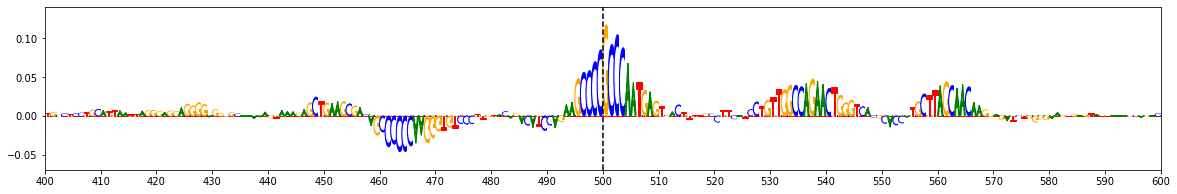

Effect Allele: T   ||   Effect Center: 0.2805   ||   Center / 200bp : 0.1486

Effect Motif: GCCCCGCCCAAT


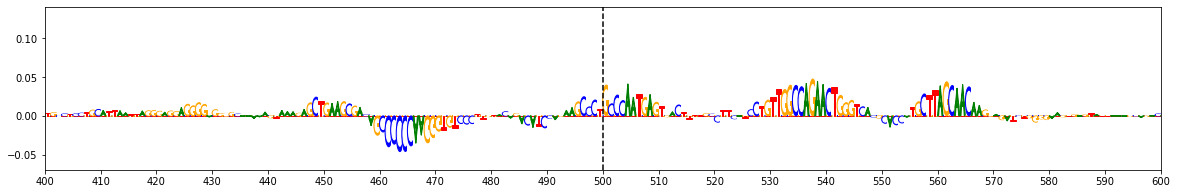

gkmExplain Score: -0.2  ||  ISM Score: -0.9251  ||  deltaSVM Score: -5.2106

gkmExplain P-Value: 0.02086  ||  ISM P-Value: 0.027618  ||  deltaSVM P-Value: 0.039899

Difference Motif: GCCC(C/T)GCCCAAT


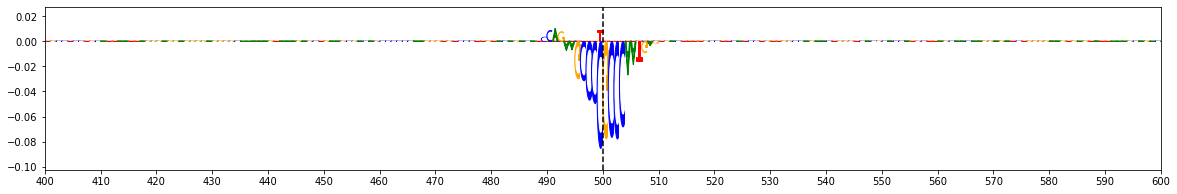



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 230

RSID: rs3810143   ||    chr19 : 44846144 - 44846145   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 5.9756E-50   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: T   ||   Noneffect Center: 0.7791   ||   Center / 200bp : 0.2271

Noneffect Motif: TTCTTTGGCAG


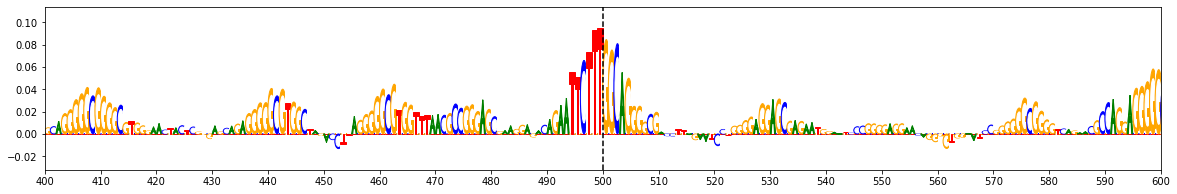

Effect Allele: C   ||   Effect Center: 0.1832   ||   Center / 200bp : 0.0666

Effect Motif: TTCTTTGGCAG


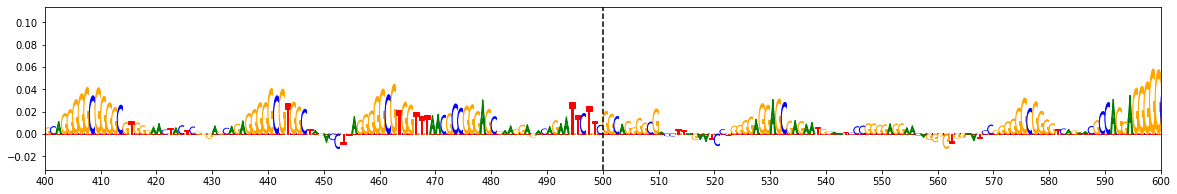

gkmExplain Score: -0.1605  ||  ISM Score: -1.1128  ||  deltaSVM Score: -6.4027

gkmExplain P-Value: 0.038373  ||  ISM P-Value: 0.014812  ||  deltaSVM P-Value: 0.022425

Difference Motif: TTCTT(T/C)GGCAG


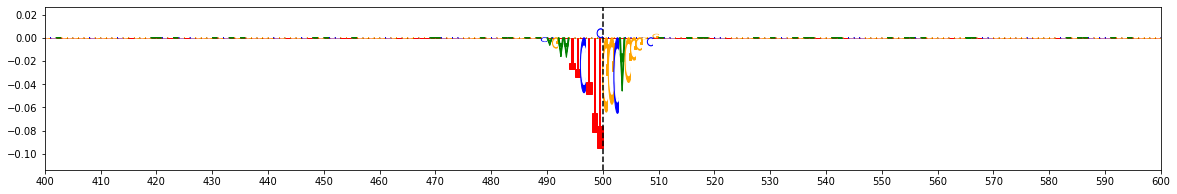



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 87

RSID: rs79436576   ||    chr17 : 4901871 - 4901872   ||    Locus: 55   ||    IDR Peak: True

GWAS: Alzheimers_Lambert_2013   ||    P-Value: 4.7890E-05   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.8559   ||   Center / 200bp : 0.2426

Noneffect Motif: GGCCCCGCCCC


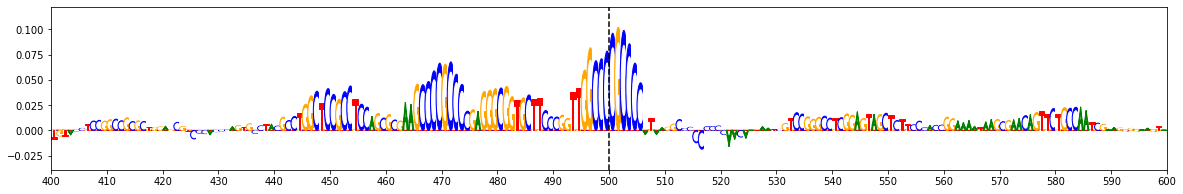

Effect Allele: T   ||   Effect Center: 0.2407   ||   Center / 200bp : 0.0829

Effect Motif: GGCCCCGCCCC


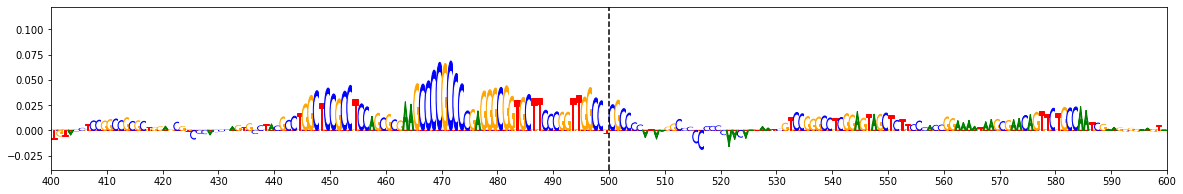

gkmExplain Score: -0.1596  ||  ISM Score: -0.9809  ||  deltaSVM Score: -5.7986

gkmExplain P-Value: 0.038919  ||  ISM P-Value: 0.022788  ||  deltaSVM P-Value: 0.029732

Difference Motif: GGCC(C/T)CGCCCC


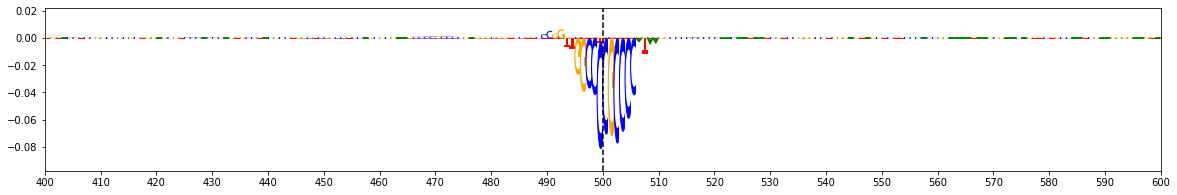



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 218

RSID: rs4802235   ||    chr19 : 44721571 - 44721572   ||    Locus: 71   ||    IDR Peak: False

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 1.0510E-13   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: G   ||   Noneffect Center: 0.6225   ||   Center / 200bp : 0.2612

Noneffect Motif: GTGGCGCAATC


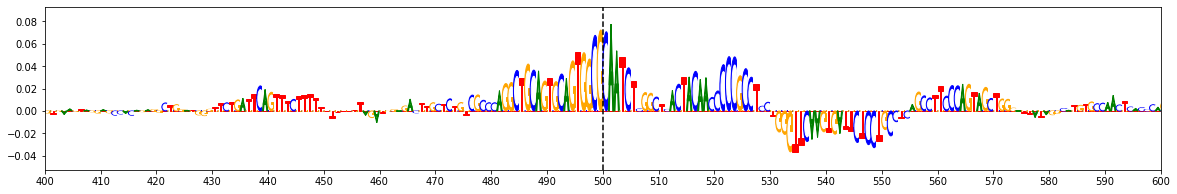

Effect Allele: T   ||   Effect Center: 0.2015   ||   Center / 200bp : 0.1063

Effect Motif: GTGGCGCAATC


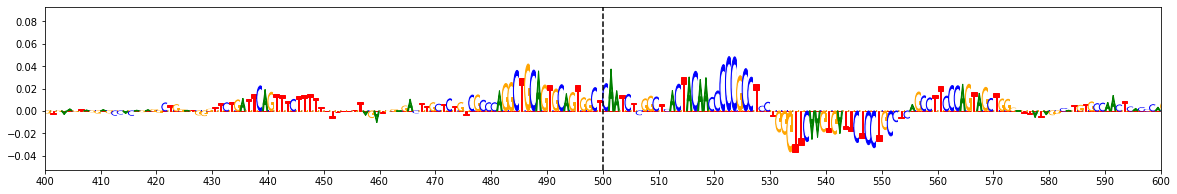

gkmExplain Score: -0.1549  ||  ISM Score: -0.8321  ||  deltaSVM Score: -4.7968

gkmExplain P-Value: 0.042178  ||  ISM P-Value: 0.038596  ||  deltaSVM P-Value: 0.0497

Difference Motif: GTGGC(G/T)CAATC


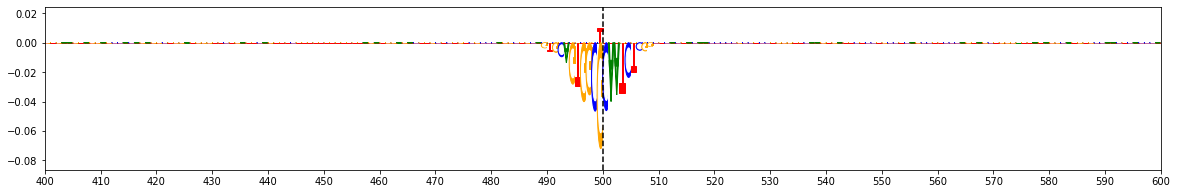



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 323

RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 92   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.3493E-03   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.7192   ||   Center / 200bp : 0.2564

Noneffect Motif: GAGGGCGCTGT


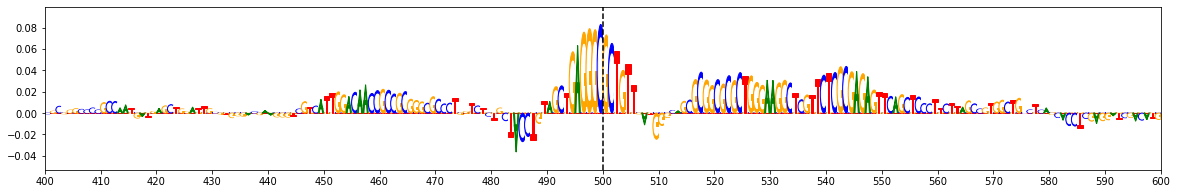

Effect Allele: T   ||   Effect Center: 0.2417   ||   Center / 200bp : 0.1065

Effect Motif: GAGGGCGCTGT


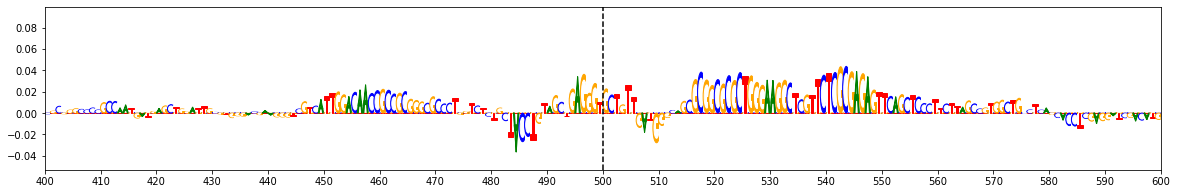

gkmExplain Score: -0.1499  ||  ISM Score: -0.8949  ||  deltaSVM Score: -5.1821

gkmExplain P-Value: 0.04589  ||  ISM P-Value: 0.03073  ||  deltaSVM P-Value: 0.040494

Difference Motif: GAGGG(C/T)GCTGT


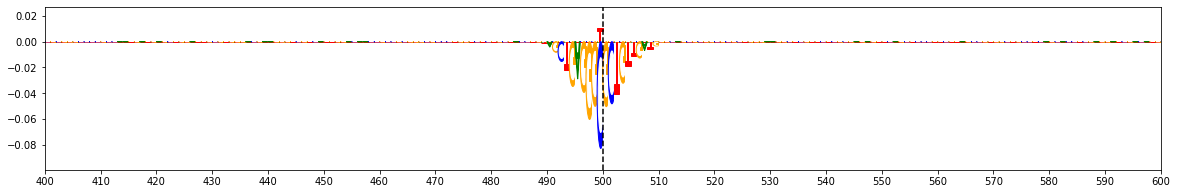



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 274

RSID: rs872580   ||    chr2 : 95057163 - 95057164   ||    Locus: 85   ||    IDR Peak: False

GWAS: Nalls_23andMe   ||    P-Value: 4.0372E-02   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: A   ||   Noneffect Center: 0.452   ||   Center / 200bp : 0.2332

Noneffect Motif: TTTCCATGGCA


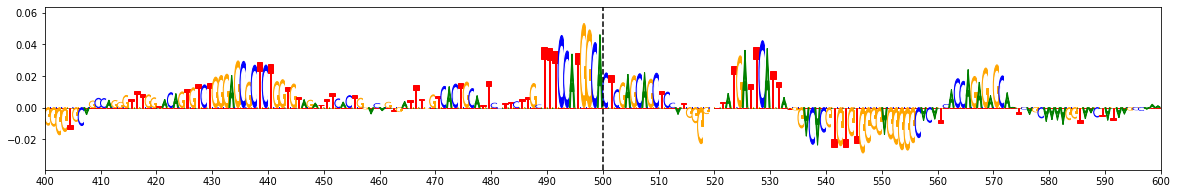

Effect Allele: C   ||   Effect Center: 0.1102   ||   Center / 200bp : 0.0917

Effect Motif: TTTCCATGGCA


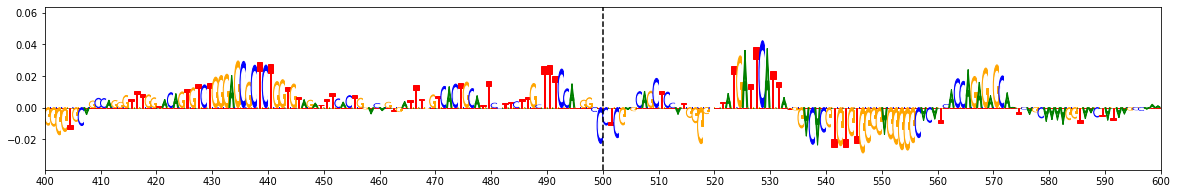

gkmExplain Score: -0.1414  ||  ISM Score: -0.8413  ||  deltaSVM Score: -4.9073

gkmExplain P-Value: 0.053327  ||  ISM P-Value: 0.037319  ||  deltaSVM P-Value: 0.046819

Difference Motif: TTTCCATGGC(A/C)


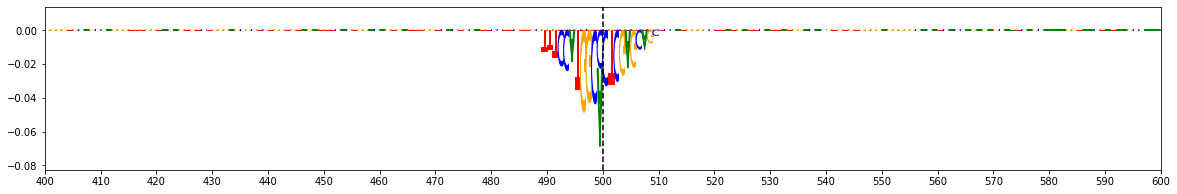



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 273

RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 1.2157E-04   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: G   ||   Noneffect Center: 0.1146   ||   Center / 200bp : 0.1388

Noneffect Motif: CCGCCTCCAC


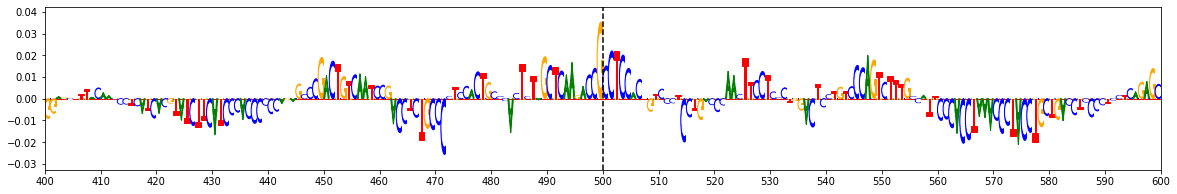

Effect Allele: C   ||   Effect Center: -0.1279   ||   Center / 200bp : 0.0

Effect Motif: CCGCCTCCAC


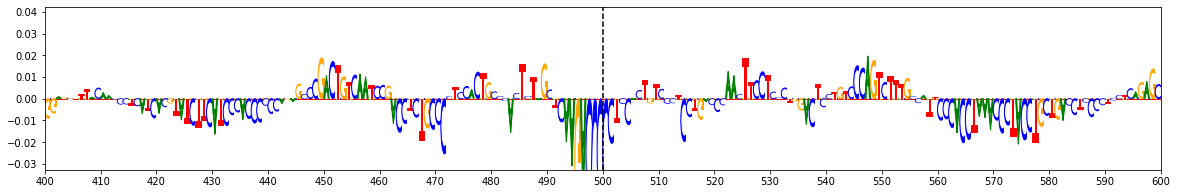

gkmExplain Score: -0.1388  ||  ISM Score: -1.0477  ||  deltaSVM Score: -6.0325

gkmExplain P-Value: 0.05595  ||  ISM P-Value: 0.018241  ||  deltaSVM P-Value: 0.026594

Difference Motif: CC(G/C)CCTCCAC


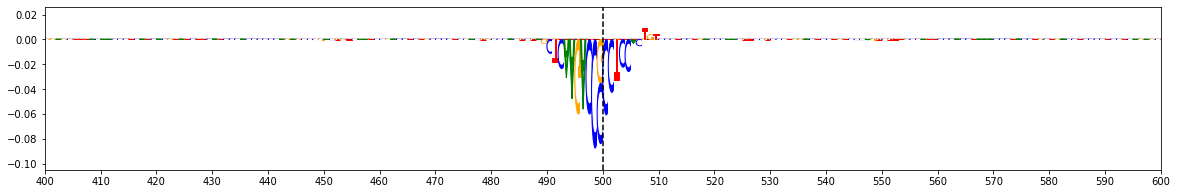



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 349

RSID: rs6791884   ||    chr3 : 183006617 - 183006618   ||    Locus: 90   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 6.0039E-09   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: A   ||   Noneffect Center: 0.705   ||   Center / 200bp : 0.2384

Noneffect Motif: AGAGCTGCCAA


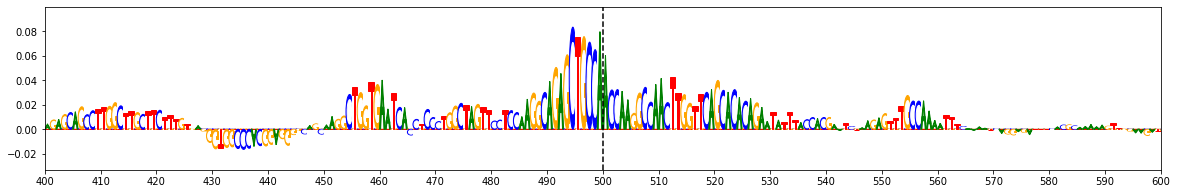

Effect Allele: G   ||   Effect Center: 0.2515   ||   Center / 200bp : 0.1043

Effect Motif: AGAGCTGCCAA


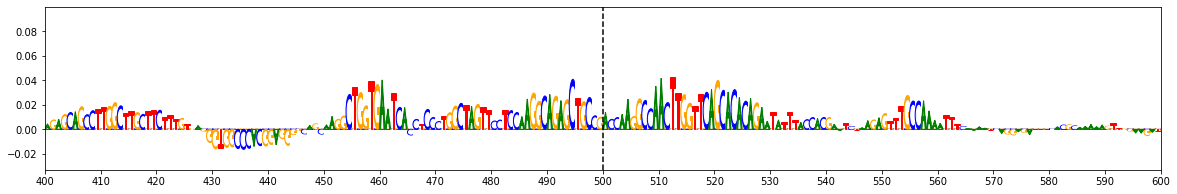

gkmExplain Score: -0.1341  ||  ISM Score: -0.8545  ||  deltaSVM Score: -4.9989

gkmExplain P-Value: 0.060938  ||  ISM P-Value: 0.03556  ||  deltaSVM P-Value: 0.044585

Difference Motif: AGAGCTGCC(A/G)A


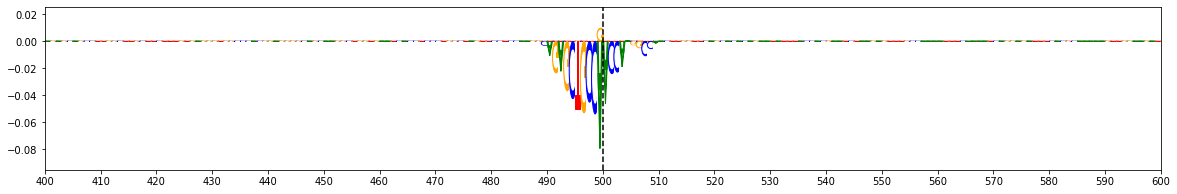



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 201

RSID: rs72914885   ||    chr17 : 78426790 - 78426791   ||    Locus: 62   ||    IDR Peak: False

GWAS: Nalls_23andMe   ||    P-Value: 4.4672E-02   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: A   ||   Noneffect Center: 0.5662   ||   Center / 200bp : 0.2128

Noneffect Motif: ACTGCCAGAGC


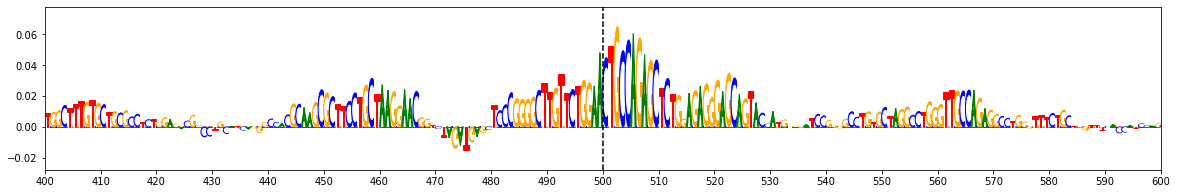

Effect Allele: C   ||   Effect Center: 0.2308   ||   Center / 200bp : 0.1257

Effect Motif: ACTGCCAGAGC


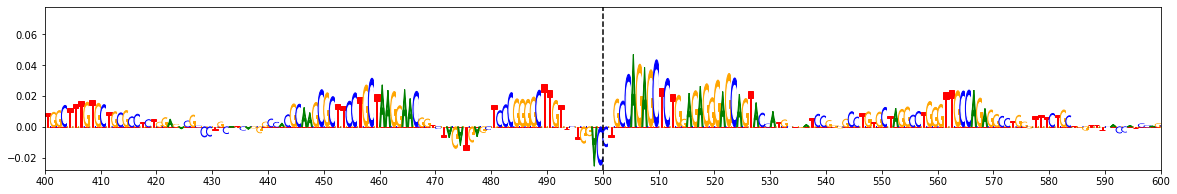

gkmExplain Score: -0.087  ||  ISM Score: -0.884  ||  deltaSVM Score: -5.2654

gkmExplain P-Value: 0.158289  ||  ISM P-Value: 0.031953  ||  deltaSVM P-Value: 0.038788

Difference Motif: (A/C)CTGCCAGAGC


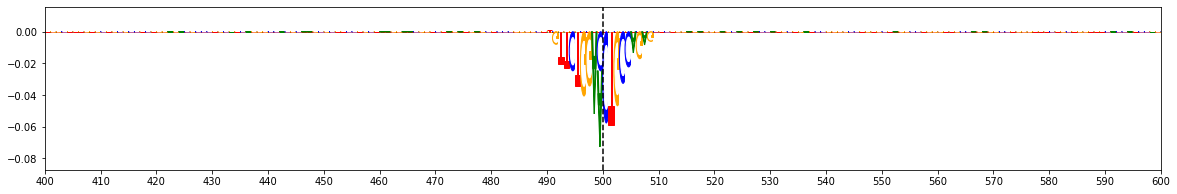



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 187

RSID: rs7218004   ||    chr17 : 75032747 - 75032748   ||    Locus: 61   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 8.5410E-06   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGCGGGTTG


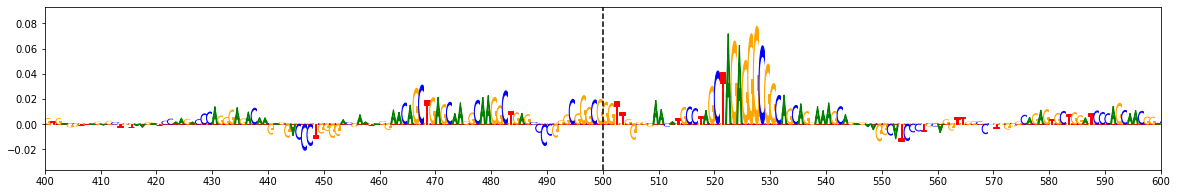

Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGCGGGTTG


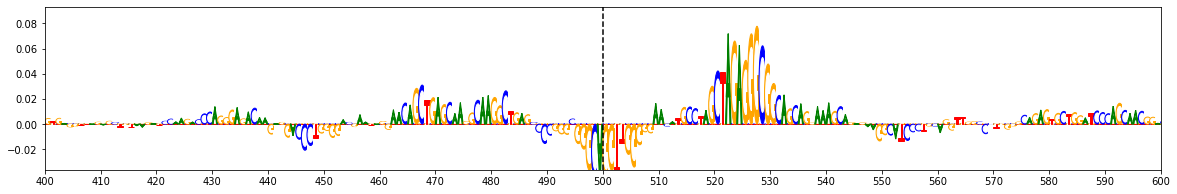

gkmExplain Score: 0.0  ||  ISM Score: -0.8814  ||  deltaSVM Score: -5.0589

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.032255  ||  deltaSVM P-Value: 0.043192

Difference Motif: GGGC(G/A)GGTTG


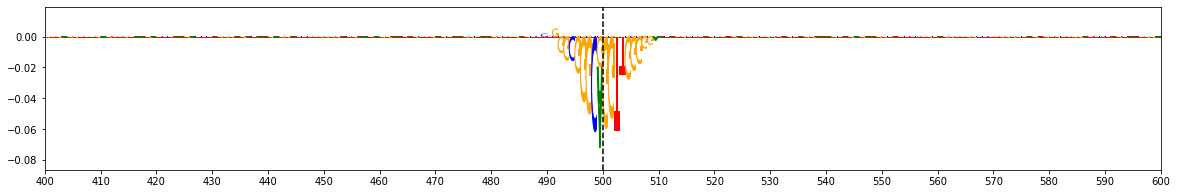



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 280

RSID: rs3755519   ||    chr2 : 95323523 - 95323524   ||    Locus: 85   ||    IDR Peak: False

GWAS: Nalls_23andMe   ||    P-Value: 7.6825E-03   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: A   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CAGGAGTGCT


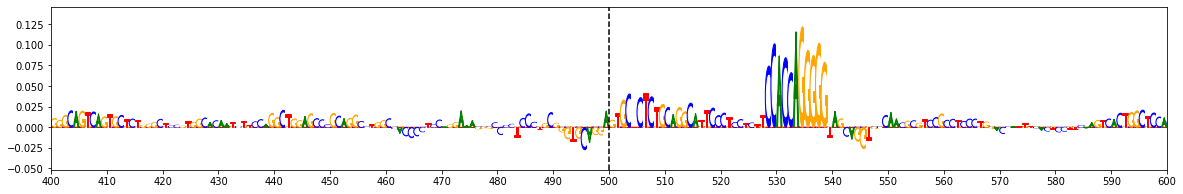

Effect Allele: T   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CAGGAGTGCT


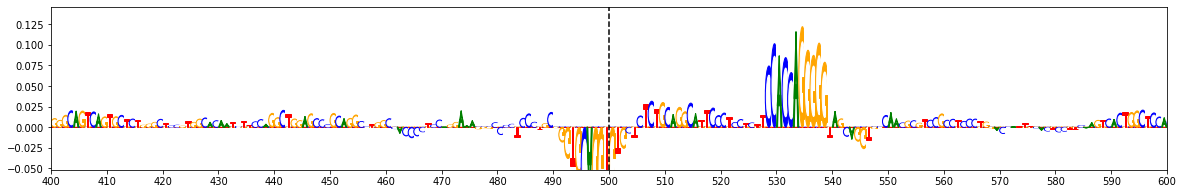

gkmExplain Score: 0.0  ||  ISM Score: -1.3344  ||  deltaSVM Score: -7.6661

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.007701  ||  deltaSVM P-Value: 0.013175

Difference Motif: CAGG(A/T)GTGCT


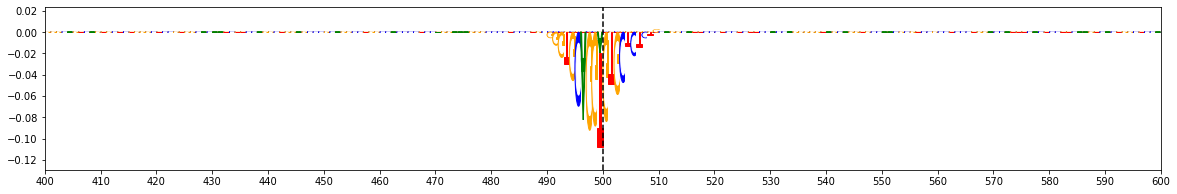



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 156

RSID: rs17651887   ||    chr17 : 45992473 - 45992474   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 2.1871E-22   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: A   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: TGAGAGTCTT


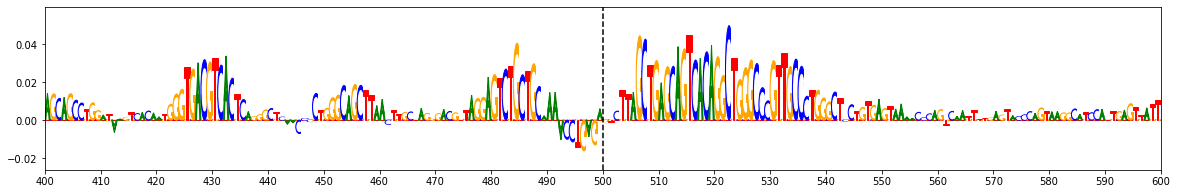

Effect Allele: G   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: TGAGAGTCTT


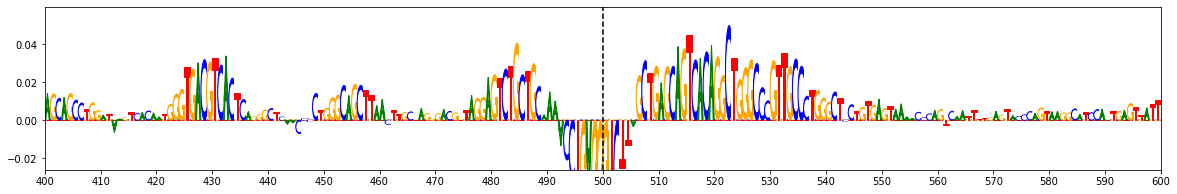

gkmExplain Score: 0.0  ||  ISM Score: -0.8598  ||  deltaSVM Score: -4.9073

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.034879  ||  deltaSVM P-Value: 0.04682

Difference Motif: TGAG(A/G)GTCTT


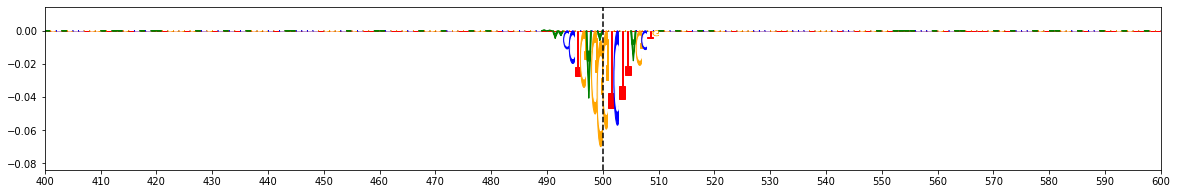



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [18]:
neg_diff_motifs = []

for idx in neg_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], 
          ':', neg_snps.at[idx, 'start'],
          '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', neg_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', neg_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(neg_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', neg_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', neg_snps.at[idx, 'confidence'])
    print()
    print()
    
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', neg_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', neg_snps.at[idx, 'major'],
              '  ||   Major Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if neg_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', neg_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', neg_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(neg_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(neg_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(neg_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(neg_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(neg_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(neg_snps.at[idx, 'delta_pval'], 6))
    print()
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'noneffect']
                      + '/' + neg_snps.at[idx, 'effect']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    else:
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'major']
                      + '/' + neg_snps.at[idx, 'minor']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    print('Difference Motif:', diff_motif)
    neg_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
neg_snps['diff_motif'] = neg_diff_motifs

# Visualize Top Positive Scoring SNPs <a name='pos_snps' />


Index: 200

RSID: rs72914883   ||    chr17 : 78426733 - 78426734   ||    Locus: 62   ||    IDR Peak: False

GWAS: Nalls_23andMe   ||    P-Value: 4.4618E-02   ||    Coloc: False   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 0.9495   ||   Center / 200bp : 0.3001

Effect Motif: GCCGCGCAAGCGC


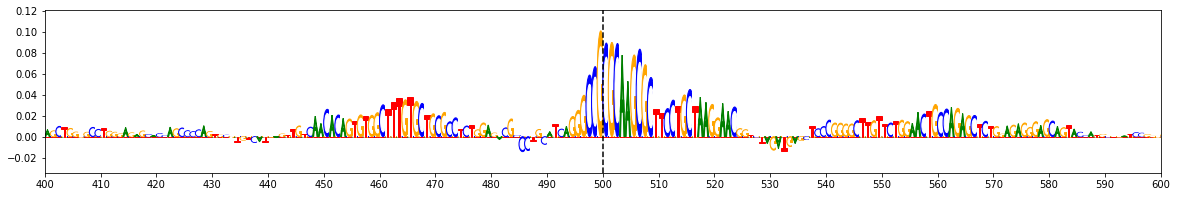

Noneffect Allele: A   ||   Noneffect Center: 0.2963   ||   Center / 200bp : 0.1219

Noneffect Motif: GCCGCGCAAGCGC


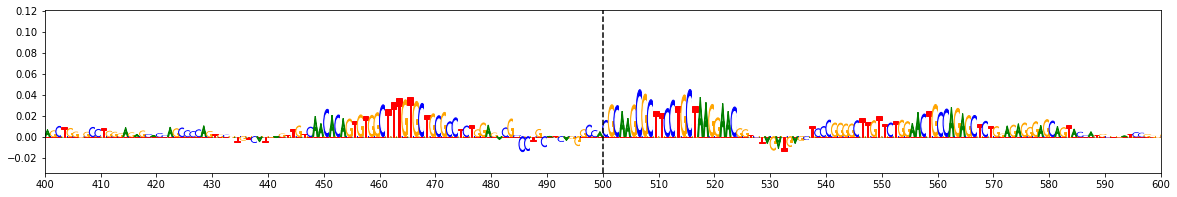

gkmExplain Score: 0.1782  ||  ISM Score: 1.183  ||  deltaSVM Score: 6.8291

gkmExplain P-Value: 0.02885  ||  ISM P-Value: 0.01193  ||  deltaSVM P-Value: 0.018587

Difference Motif: GCC(G/A)CGCAAGCGC


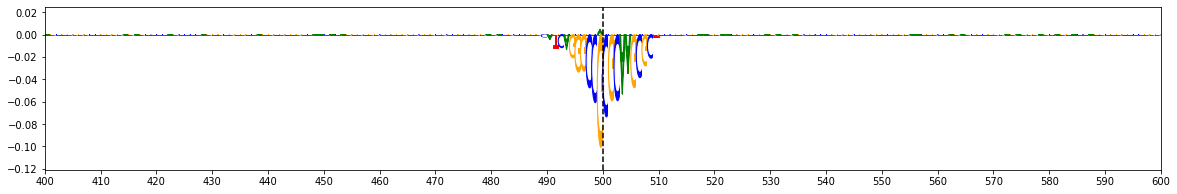



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 182

RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 9.4929E-14   ||    Coloc: True   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 0.8717   ||   Center / 200bp : 0.2844

Effect Motif: GCGCCACCTAC


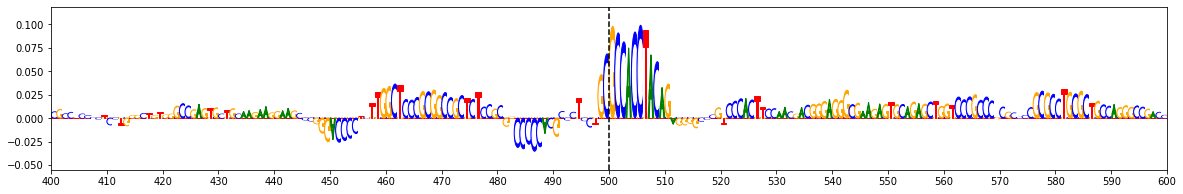

Noneffect Allele: A   ||   Noneffect Center: 0.2438   ||   Center / 200bp : 0.1097

Noneffect Motif: GCGCCACCTAC


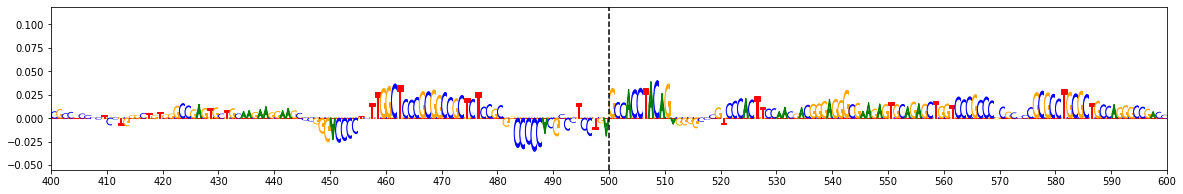

gkmExplain Score: 0.1747  ||  ISM Score: 1.0929  ||  deltaSVM Score: 6.3148

gkmExplain P-Value: 0.030486  ||  ISM P-Value: 0.015771  ||  deltaSVM P-Value: 0.023337

Difference Motif: G(C/A)GCCACCTAC


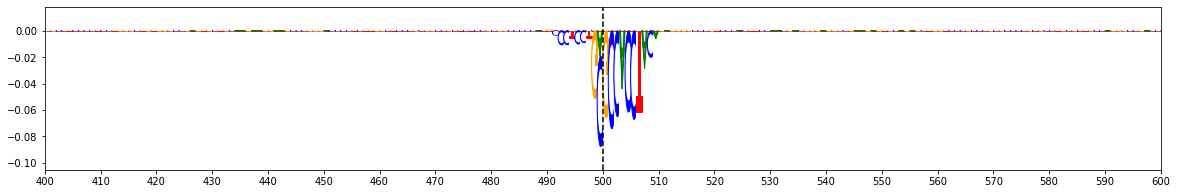



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 419

RSID: rs1736081   ||    chr8 : 11845330 - 11845331   ||    Locus: 122   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 1.1147E-04   ||    Coloc: False   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.074   ||   Center / 200bp : 0.0741

Effect Motif: GCTGTTGGCC


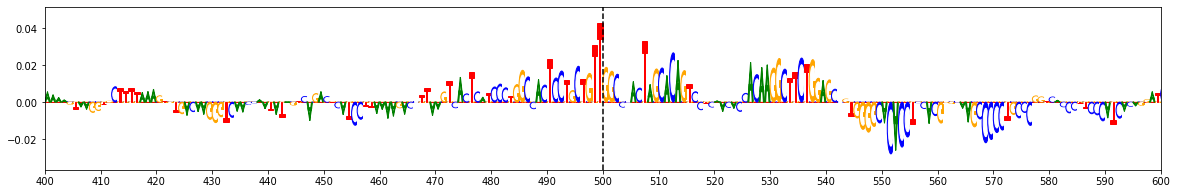

Noneffect Allele: G   ||   Noneffect Center: -0.0877   ||   Center / 200bp : 0.0

Noneffect Motif: GCTGTTGGCC


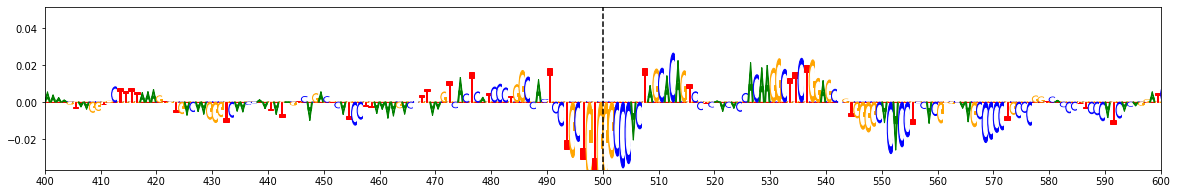

gkmExplain Score: 0.0741  ||  ISM Score: 1.1336  ||  deltaSVM Score: 6.5631

gkmExplain P-Value: 0.211265  ||  ISM P-Value: 0.013877  ||  deltaSVM P-Value: 0.020875

Difference Motif: GCTGT(T/G)GGCC


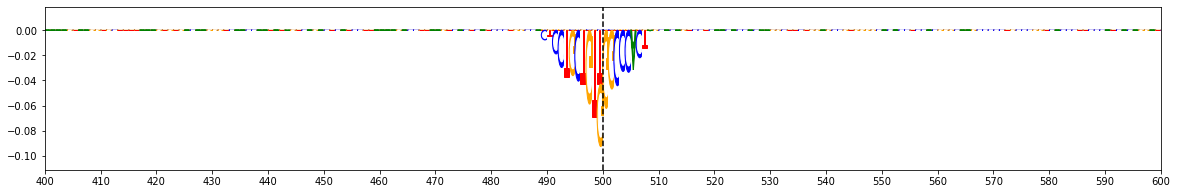



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 57

RSID: rs143560707   ||    chr15 : 64453059 - 64453060   ||    Locus: 43   ||    IDR Peak: True

GWAS: Alzheimers_Lambert_2013   ||    P-Value: 3.0280E-06   ||    Coloc: True   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0336   ||   Center / 200bp : 0.039

Effect Motif: CACAGCTGTA


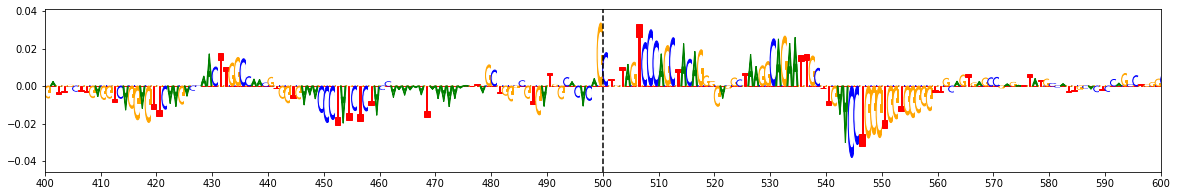

Noneffect Allele: C   ||   Noneffect Center: -0.0964   ||   Center / 200bp : 0.0

Noneffect Motif: CACAGCTGTA


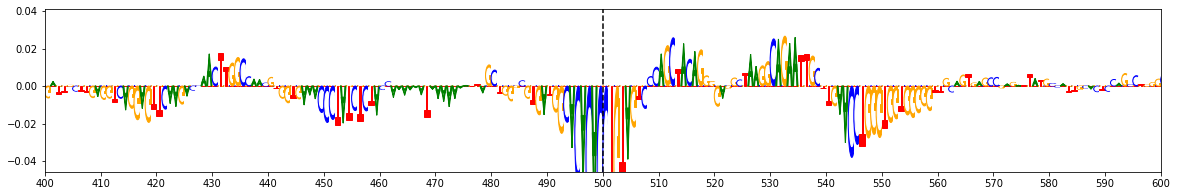

gkmExplain Score: 0.039  ||  ISM Score: 1.6059  ||  deltaSVM Score: 9.2876

gkmExplain P-Value: 0.469537  ||  ISM P-Value: 0.003822  ||  deltaSVM P-Value: 0.007313

Difference Motif: CACA(G/C)CTGTA


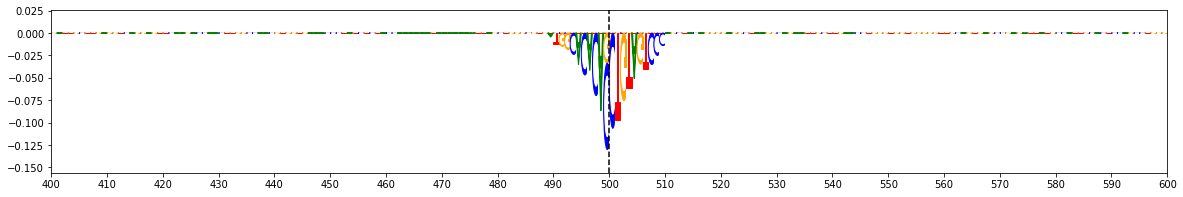



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 279

RSID: rs2248415   ||    chr2 : 95297493 - 95297494   ||    Locus: 85   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 7.8283E-03   ||    Coloc: False   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.036   ||   Center / 200bp : 0.0283

Effect Motif: GGGTGGGGGG


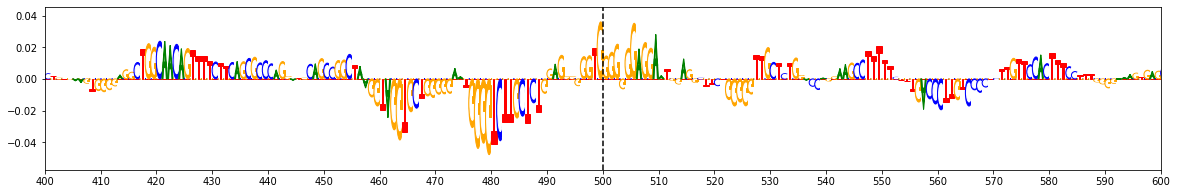

Noneffect Allele: C   ||   Noneffect Center: -0.0733   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTGGGGGG


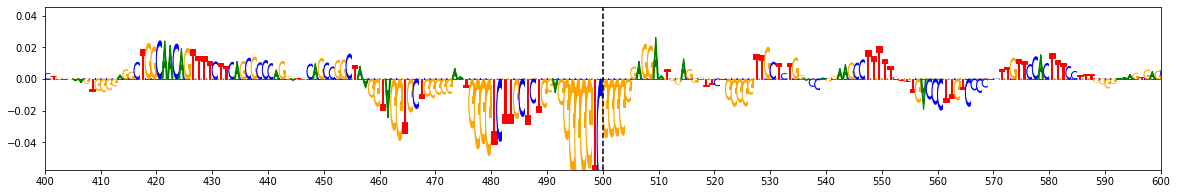

gkmExplain Score: 0.0283  ||  ISM Score: 1.3665  ||  deltaSVM Score: 7.9079

gkmExplain P-Value: 0.592262  ||  ISM P-Value: 0.007051  ||  deltaSVM P-Value: 0.011995

Difference Motif: GGGT(G/C)GGGGG


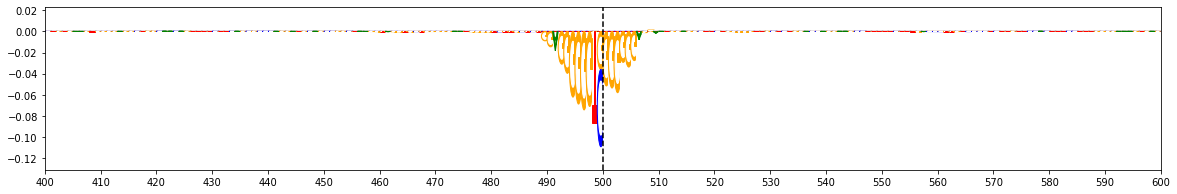



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 426

RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 125   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 5.0811E-02   ||    Coloc: False   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0378   ||   Center / 200bp : 0.0253

Effect Motif: CCCCTGCCGC


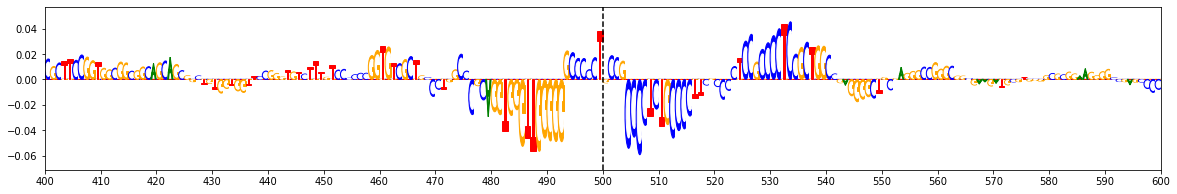

Noneffect Allele: C   ||   Noneffect Center: -0.0548   ||   Center / 200bp : 0.0

Noneffect Motif: CCCCTGCCGC


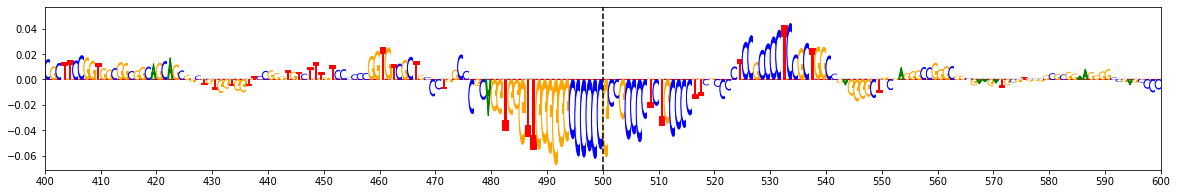

gkmExplain Score: 0.0253  ||  ISM Score: 1.0703  ||  deltaSVM Score: 7.1612

gkmExplain P-Value: 0.630821  ||  ISM P-Value: 0.016953  ||  deltaSVM P-Value: 0.016155

Difference Motif: CCCC(T/C)GCCGC


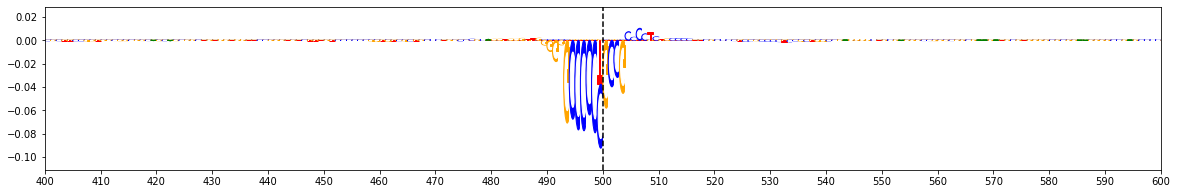



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 27

RSID: rs2231884   ||    chr11 : 65889092 - 65889093   ||    Locus: 13   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 2.3681E-06   ||    Coloc: True   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0289   ||   Center / 200bp : 0.0207

Effect Motif: GCCCTTCAAA


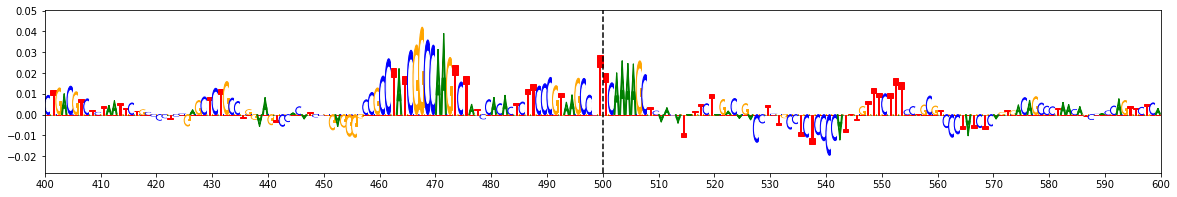

Noneffect Allele: C   ||   Noneffect Center: -0.043   ||   Center / 200bp : 0.0

Noneffect Motif: GCCCTTCAAA


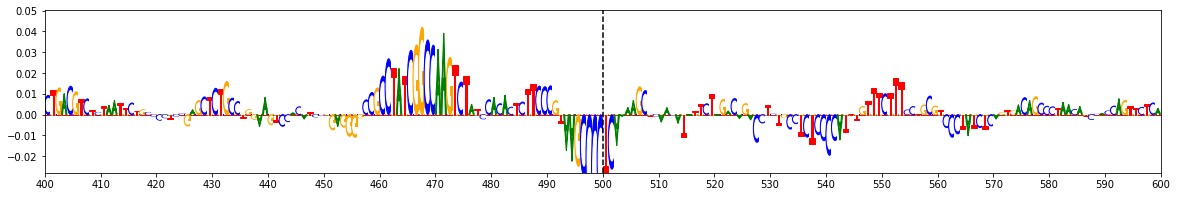

gkmExplain Score: 0.0207  ||  ISM Score: 0.8862  ||  deltaSVM Score: 5.0906

gkmExplain P-Value: 0.691301  ||  ISM P-Value: 0.031709  ||  deltaSVM P-Value: 0.042476

Difference Motif: GCCC(T/C)TCAAA


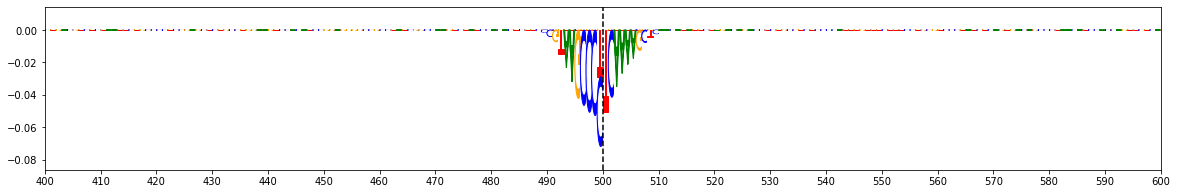



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 92

RSID: rs7214776   ||    chr17 : 4908319 - 4908320   ||    Locus: 55   ||    IDR Peak: True

GWAS: Alzheimers_Lambert_2013   ||    P-Value: 4.2660E-05   ||    Coloc: True   ||    Confidence: 0


Effect Allele: C   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CACCCGAGAG


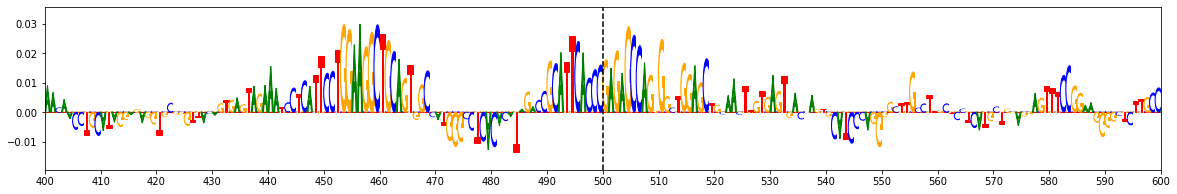

Noneffect Allele: T   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CACCCGAGAG


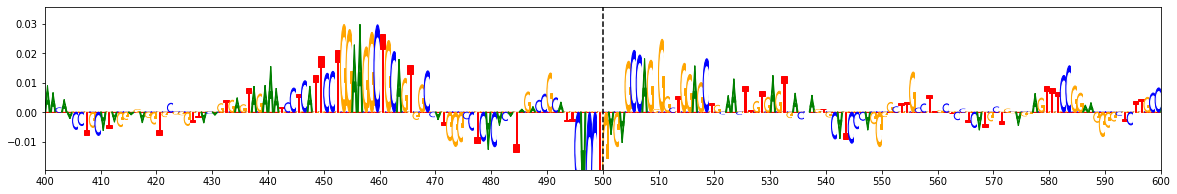

gkmExplain Score: 0.0  ||  ISM Score: 0.8414  ||  deltaSVM Score: 4.8254

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.037297  ||  deltaSVM P-Value: 0.048934

Difference Motif: CACC(C/T)GAGAG


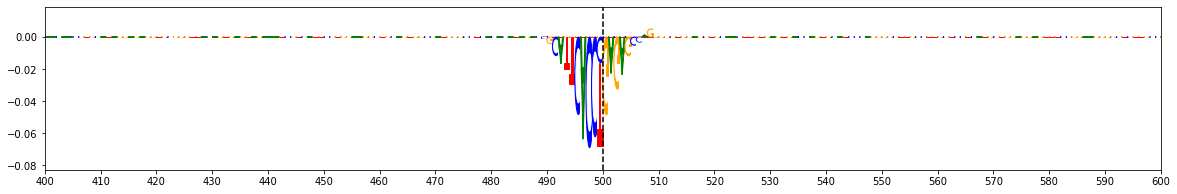



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 242

RSID: rs72654437   ||    chr19 : 44912841 - 44912842   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.2830E-09   ||    Coloc: True   ||    Confidence: 0


Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: TGTGAGGTCT


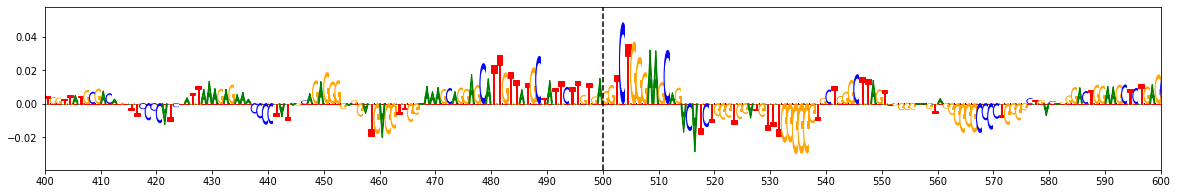

Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: TGTGAGGTCT


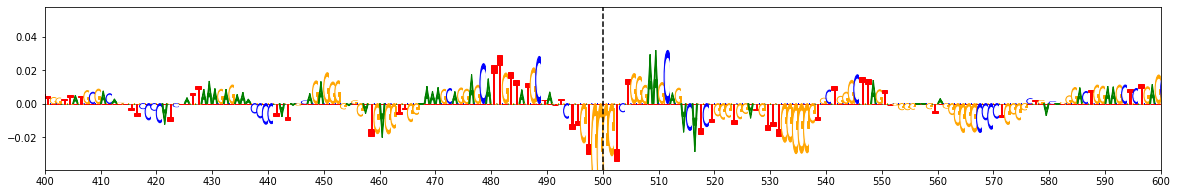

gkmExplain Score: 0.0  ||  ISM Score: 0.8735  ||  deltaSVM Score: 5.0129

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.033184  ||  deltaSVM P-Value: 0.044256

Difference Motif: TGTG(A/G)GGTCT


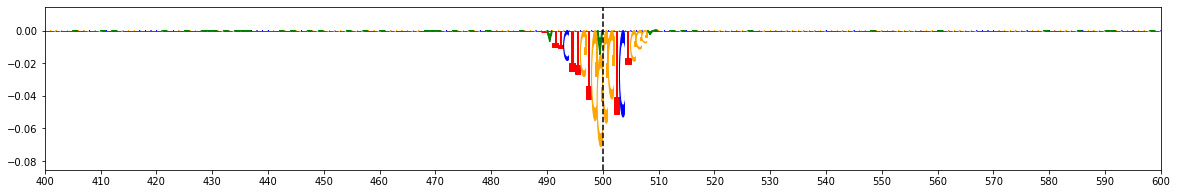



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 247

RSID: rs12691088   ||    chr19 : 44915228 - 44915229   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.6900E-238   ||    Coloc: True   ||    Confidence: 0


Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGTAGGGGG


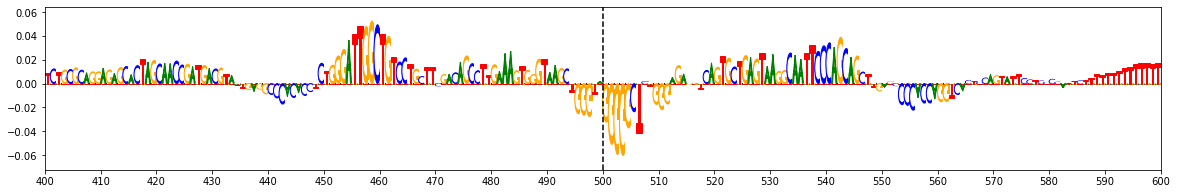

Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTAGGGGG


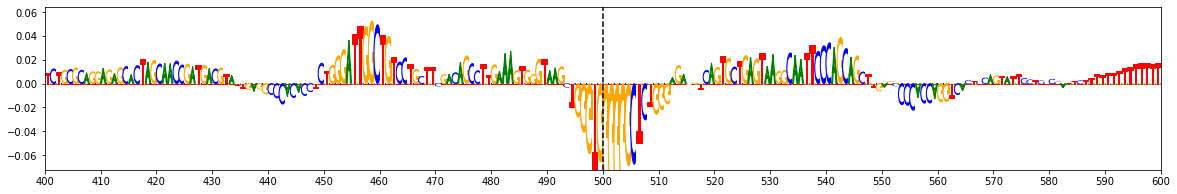

gkmExplain Score: 0.0  ||  ISM Score: 0.8881  ||  deltaSVM Score: 5.1258

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.031494  ||  deltaSVM P-Value: 0.0417

Difference Motif: GGGT(A/G)GGGGG


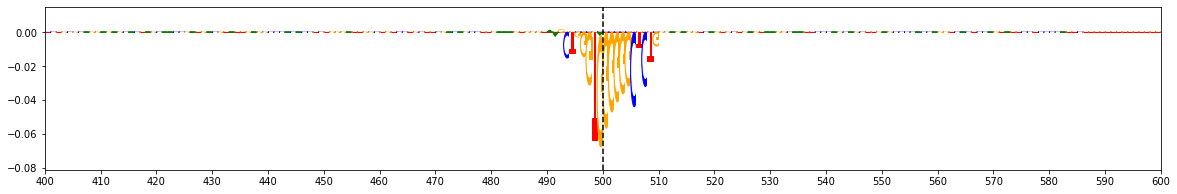



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [19]:
pos_diff_motifs = []

for idx in pos_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], 
          ':', pos_snps.at[idx, 'start'],
          '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', pos_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', pos_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(pos_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', pos_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', pos_snps.at[idx, 'confidence'])
    print()
    print()
    
    if pos_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', pos_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', pos_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if pos_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', pos_snps.at[idx, 'major'],
              '  ||   Major Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(pos_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(pos_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(pos_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(pos_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(pos_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(pos_snps.at[idx, 'delta_pval'], 6))
    print()
    if pos_snps.at[idx, 'effect'] != 'NAN':
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'effect']
                      + '/' + pos_snps.at[idx, 'noneffect']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    else:
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'minor']
                      + '/' + pos_snps.at[idx, 'major']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    pos_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
pos_snps['diff_motif'] = pos_diff_motifs

# Generate Signal Tracks

In [20]:
clust_to_celltype = {1: 'excitatory_neurons', 
                     2: 'inhibitory_neurons',
                     3: 'excitatory_neurons',
                     4: 'excitatory_neurons',
                     5: 'nigral_neurons',
                     6: 'nigral_neurons',
                     7: 'unknown_neurons',
                     8: 'opcs',
                     9: 'opcs',
                     10: 'opcs',
                     11: 'inhibitory_neurons',
                     12: 'inhibitory_neurons',
                     13: 'astrocytes',
                     14: 'astrocytes',
                     15: 'astrocytes',
                     16: 'astrocytes',
                     17: 'astrocytes',
                     18: 'doublets',
                     19: 'oligodendrocytes',
                     20: 'oligodendrocytes',
                     21: 'oligodendrocytes',
                     22: 'oligodendrocytes',
                     23: 'oligodendrocytes',
                     24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

sig_snps = neg_snps.append(pos_snps)
tomtom = ['---' for x in range(len(sig_snps))]
fc_tracks = []
pval_tracks = []
tfactors = ['---' for x in range(len(sig_snps))]
annotations = ['---' for x in range(len(sig_snps))]

for index, row in sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/'+rsid+'.pval.png')
        
sig_snps['tomtom'] = tomtom
sig_snps['fc_track'] = fc_tracks
sig_snps['pval_track'] = pval_tracks
sig_snps['tfactor'] = tfactors
sig_snps['annotation'] = annotations

sig_snps = sig_snps[['chr', 'start', 'end', 'rsid',
                     'effect', 'noneffect', 'direction',
                     'locus_num', 'gwas', 'gwas_pval', 'coloc',
                     'idr_peak', 'ism_pval', 'delta_pval', 'ratio_pval',
                     'confidence', 'motif', 'diff_motif', 'tomtom', 'fc_track',
                     'pval_track', 'tfactor', 'annotation']]

sig_snps.rename(columns = {'ratio_pval': 'explain_pval'}, inplace=True)
sig_snps.sort_values(by=['explain_pval'], ascending=True, inplace=True)

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.04244589805603027
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:py

INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.0450282096862793
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 1

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.05911827087402344
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.05189919471740723
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotti

INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygeno

INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.07232117652893066
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. 

INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:

INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.08732724189758301
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spac

# Save Significant SNPs

In [21]:
sig_snps.to_csv('/mnt/lab_data3/soumyak/adpd/sig_snps/Cluster'
                + cluster
                + '.'
                + celltype
                + '.snps.csv',
                sep='\t', index=False)

# Final SNP Table <a name='final_table' />

In [22]:
display(sig_snps)

,chr,start,end,rsid,effect,noneffect,direction,locus_num,gwas,gwas_pval,coloc,idr_peak,ism_pval,delta_pval,explain_pval,confidence,motif,diff_motif,tomtom,fc_track,pval_track,tfactor,annotation
303,chr2,127128581,127128582,rs13025717,T,C,+,77,Alzheimers_Jansen_2018,9.125833e-17,False,False,0.027618,0.039899,0.020860,2,GCCCCGCCCAAT,GCCC(C/T)GCCCAAT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
200,chr17,78426733,78426734,rs72914883,G,A,-,62,Nalls_23andMe,4.461790e-02,False,False,0.011930,0.018587,0.028850,2,GCCGCGCAAGCGC,GCC(G/A)CGCAAGCGC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
182,chr17,46771150,46771151,rs199523,C,A,-,54,23andme_PD_hg38,9.492900e-14,True,True,0.015771,0.023337,0.030486,2,GCGCCACCTAC,G(C/A)GCCACCTAC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
230,chr19,44846144,44846145,rs3810143,C,T,+,71,Alzheimers_Jansen_2018,5.975633e-50,True,True,0.014812,0.022425,0.038373,2,TTCTTTGGCAG,TTCTT(T/C)GGCAG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
87,chr17,4901871,4901872,rs79436576,T,C,+,55,Alzheimers_Lambert_2013,4.789000e-05,True,True,0.022788,0.029732,0.038919,2,GGCCCCGCCCC,GGCC(C/T)CGCCCC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
218,chr19,44721571,44721572,rs4802235,T,G,-,71,Alzheimers_Kunkle_2019,1.051000e-13,True,False,0.038596,0.049700,0.042178,2,GTGGCGCAATC,GTGGC(G/T)CAATC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
323,chr3,49007333,49007334,rs6781790,T,C,+,92,Chang_23andMe_Parkinsons,2.349340e-03,False,True,0.030730,0.040494,0.045890,2,GAGGGCGCTGT,GAGGG(C/T)GCTGT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
274,chr2,95057163,95057164,rs872580,C,A,-,85,Nalls_23andMe,4.037170e-02,False,False,0.037319,0.046819,0.053327,1,TTTCCATGGCA,TTTCCATGGC(A/C),---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
273,chr19,45326535,45326536,rs344791,C,G,-,71,Alzheimers_Jansen_2018,1.215671e-04,True,True,0.018241,0.026594,0.055950,1,CCGCCTCCAC,CC(G/C)CCTCCAC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
349,chr3,183006617,183006618,rs6791884,G,A,-,90,23andme_PD_hg38,6.003890e-09,False,True,0.035560,0.044585,0.060938,1,AGAGCTGCCAA,AGAGCTGCC(A/G)A,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
